In [393]:
import torch
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the data

routine.py

In [407]:
import csv
def return_HM_npy(csvfile_path):
    H=[]
    M=[]
    with open(csvfile_path, 'r') as f:
        reader=csv.reader(f)
        header=next(reader) #skip header
        for row in reader:
            H.append(float(row[0]))
            M.append(float(row[1]))
    return np.array(H), np.array(M)

def accept_middle(H, M, noise_std=0.1, f=None):
    noise=abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else: return False

def generate_data(noise_std=0.1, datasize=10000, Hrange=[0.0, 6.0], Mrange=[0.0, 2.0], f=None):
    Hp=[]
    Mp=[]
    Fp=[]
    Hn=[]
    Mn=[]
    Fn=[]
    while True:
        H=np.random.uniform(Hrange[0], Hrange[1])
        M=np.random.uniform(Mrange[0], Mrange[1])
        if accept_middle(H, M, noise_std, f) and len(Hp)<datasize:
            Hp.append([H])
            Mp.append([M])
            Fp.append([0])
        elif len(Hn)<datasize:
            Hn.append([H])
            Mn.append([M])
            Fn.append([1])
        if len(Hp)>=datasize and len(Hn)>=datasize:
            break
    return (np.array(Hp), np.array(Mp), np.array(Fp)), (np.array(Hn), np.array(Mn), np.array(Fn))

def plot_all(H, M, Positive_HM, Negative_HM, f):
    plt.xlabel('H')
    plt.ylabel('M')
    plt.plot(Negative_HM[0], Negative_HM[1], 'y.', label='negative')
    plt.plot(Positive_HM[0], Positive_HM[1], 'b.', label='positive')
    hs=np.linspace(np.min(H), np.max(H), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(H, M, 'ro', label='data')
    plt.legend(loc='upper right',bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()

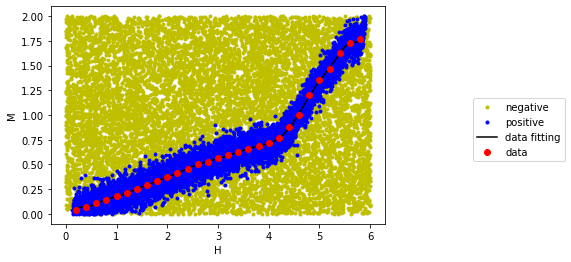

In [408]:
H,M=return_HM_npy('MHfile.csv')
f=np.poly1d(np.polyfit(H,M,deg=15))
Positive_HM, Negative_HM = generate_data(datasize=10000, f=f)
plot_all(H, M, Positive_HM, Negative_HM, f)

## Reformat training data
Make training data by class called 'Dataset'.

In [409]:
class phi_pi_dataset:
    def __init__(self, Positive_HM, Negative_HM, transform=None):
        self.phi=np.concatenate((Positive_HM[0], Negative_HM[0]), axis=0).astype(np.float32)
        self.pi=np.concatenate((Positive_HM[1], Negative_HM[1]), axis=0).astype(np.float32)
        self.ans = np.concatenate((Positive_HM[2], Negative_HM[2]), axis=0).astype(np.float32)
        self.transform=transform
    def __getitem__(self, index):
        phi=self.phi[index]
        pi=self.pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi=self.transform(phi)
            pi=self.transform(pi)
            ans = self.transform(ans)
        return phi, pi, ans
    def __len__(self):
        return len(self.phi)

In [410]:
train_d_loader = DataLoader(phi_pi_dataset(
                                Positive_HM=Positive_HM, 
                                Negative_HM=Negative_HM, 
                                transform=transforms.Compose([torch.from_numpy])), 
                                batch_size=100, shuffle=True)

# 2. Make a Neural network
neuralnet.py

In [411]:
import torch.nn as nn
import torch.nn.functional as F

def onestep(phi, pi, hh=None, m2=None, lamb=None, del_eta=None, alpha=None, beta=None):
    phi1 = phi + del_eta*pi
    pi1 = phi*m2*del_eta + (1-del_eta*hh)*pi + del_eta*lamb*(phi1**3)
    return phi1, pi1

def f(phi, pi):
    return pi
def t(a):
    return 0.5*(torch.tanh(100*(a-0.1))-torch.tanh(100*(a+0.1))+2)

class Metricnet(nn.Module):
    def __init__(self, N_layer=None, eta_ini=None, eta_fin=None, del_eta=None, d=None):
        super(Metricnet, self).__init__()
        
        #trained parameters
        Hs=[]
        for layer_index in range (N_layer):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs=nn.ModuleList(Hs)
        self.lamb=nn.Linear(1, 1, bias=False)
        self.m2=nn.Linear(1, 1, bias=False)
        self.alpha=nn.Linear(1, 1, bias=False)
        self.beta=nn.Linear(1, 1, bias=False)
        
        #fixed parameters
        self.N_layer=N_layer
        self.eta_ini=eta_ini
        self.eta_fin=eta_fin
        self.del_eta=del_eta
        self.d=d
        self.one=Variable(torch.ones(1))
        
    def show_lamb(self):
        return self.lamb(self.one)
    def show_m2(self):
        return self.m2(self.one)
    def show_alpha(self):
        return self.alpha(self.one)
    def show_beta(self):
        return self.beta(self.one)
    
    def penalty(self):
        pen=0
        for i in range (self.N_layer-1):
            H1=self.Hs[i](self.one)
            H2=self.Hs[i+1](self.one)
            pen=pen+c_reg1*((eta_ini+i*del_eta)**4)*((H2-H1)**2)
        pen=pen+c_reg2*((self.Hs[N_layer-1](self.one)-N_layer)**2)
        return pen
    
    def forward(self, H=None, M=None):
        #initial layer
        D=torch.sqrt(torch.abs(1+4*self.m2(self.one)/(self.Hs[0](self.one)**2)))
        phi=self.alpha(self.one)*H + self.beta(self.one)*M
        pi=(d/2)*(D-1)*self.alpha(self.one)*H + (d/2)*(-D-1)*self.beta(self.one)*M
        for i in range (self.N_layer-1):
            phi, pi = onestep(phi, pi, hh=self.Hs[i](self.one), m2=self.m2(self.one), 
                              lamb=self.lamb(self.one), del_eta=self.del_eta, 
                              alpha=self.alpha(self.one), beta=self.beta(self.one))
        ff=f(phi, pi)
        final=t(ff)
        return final
    
    def loss(self, phi=None, pi=None, answer=None):
        model_output=self.forward(H=phi, M=pi)
        loss=F.l1_loss(model_output, answer)**2
        loss=loss+self.penalty()
        return loss

def init_weights(Model, d):
    for i in range (len(Model.Hs)):
        w=np.random.normal(2, 1)
        Model.Hs[i].weight.data.fill_(w)
    m2=np.random.normal(2, 1)
    lamb=np.random.normal(1, 1)
    alpha=np.random.uniform(-0.5, 0.5)
    beta=np.random.uniform(-0.5, 0.5)
    Model.m2.weight.data.fill_(m2)
    Model.lamb.weight.data.fill_(lamb)
    Model.alpha.weight.data.fill_(alpha)
    Model.beta.weight.data.fill_(beta)    

In [412]:
d=4
N_layer=10
eta_fin=1/N_layer
eta_ini=1
del_eta=(eta_fin-eta_ini)/N_layer
c_reg1=0.05
c_reg2=0.0001

#make network
Test=Metricnet(N_layer=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, del_eta=del_eta, d=d)
init_weights(Test, d)

In [413]:
#setting it to be trained
optimizer = torch.optim.Adam(Test.parameters())
Test.train()

Metricnet(
  (Hs): ModuleList(
    (0): Linear(in_features=1, out_features=1, bias=False)
    (1): Linear(in_features=1, out_features=1, bias=False)
    (2): Linear(in_features=1, out_features=1, bias=False)
    (3): Linear(in_features=1, out_features=1, bias=False)
    (4): Linear(in_features=1, out_features=1, bias=False)
    (5): Linear(in_features=1, out_features=1, bias=False)
    (6): Linear(in_features=1, out_features=1, bias=False)
    (7): Linear(in_features=1, out_features=1, bias=False)
    (8): Linear(in_features=1, out_features=1, bias=False)
    (9): Linear(in_features=1, out_features=1, bias=False)
  )
  (lamb): Linear(in_features=1, out_features=1, bias=False)
  (m2): Linear(in_features=1, out_features=1, bias=False)
  (alpha): Linear(in_features=1, out_features=1, bias=False)
  (beta): Linear(in_features=1, out_features=1, bias=False)
)

# 3. Train NN

In [419]:
def plot_metric(threshold=None, Positive_HM=None, Negative_HM=None, Net=None):
    NN_pphi=[]
    NN_ppi=[]
    Negative_H = Negative_HM[0]
    Negative_M = Negative_HM[1]
    phis = Variable(torch.from_numpy(Negative_H.astype(np.float32)))
    pis = Variable(torch.from_numpy(Negative_M.astype(np.float32)))
    predict = Net.forward(H=phis, M=pis).data.numpy()
    
    for index in range (len(phis)):
        value = predict[index]
        if value < threshold:
            NN_pphi.append(Negative_H[index])
            NN_ppi.append(Negative_M[index])
    NN_pphi1=np.array(NN_pphi)
    NN_ppi1=np.array(NN_ppi)
    
    NN_pphi=[]
    NN_ppi=[]
    Positive_H = Positive_HM[0]
    Positive_M = Positive_HM[1]
    phis = Variable(torch.from_numpy(Negative_H.astype(np.float32)))
    pis = Variable(torch.from_numpy(Negative_M.astype(np.float32)))
    predict = Net.forward(H=phis, M=pis).data.numpy()
    
    for index in range (len(phis)):
        value = predict[index]
        if value < threshold:
            NN_pphi.append(Positive_H[index])
            NN_ppi.append(Positive_M[index])
    NN_pphi2=np.array(NN_pphi)
    NN_ppi2=np.array(NN_ppi)
    
    plt.plot(NN_pphi1, NN_ppi1, 'm.', label='NN(n)=0')
    plt.plot(NN_pphi2, NN_ppi2, 'r.', label='NN(p)=0')
    plt.show()
    
    x = np.array([0.1*i for i in range (10)])
    NN_list=[]
    for param in Net.Hs.parameters():
        w = (param.data.numpy().reshape(-1)).tolist()
        NN_list.append(w)
    plt.plot(x, np.array(NN_list))
    plt.show()
    
    return NN_pphi1, NN_ppi1, NN_pphi2, NN_ppi2, NN_list

0


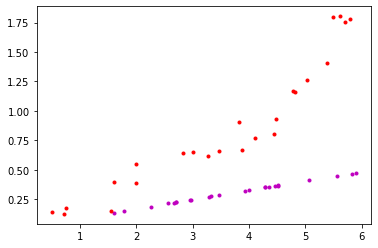

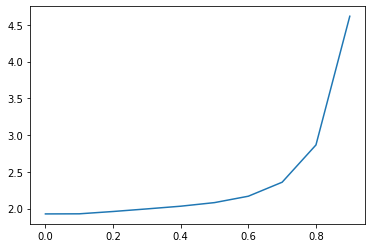

0 tensor(50.9847)
tensor([3.3595], grad_fn=<SqueezeBackward3>) tensor([0.1528], grad_fn=<SqueezeBackward3>) tensor([0.2353], grad_fn=<SqueezeBackward3>) tensor([0.4858], grad_fn=<SqueezeBackward3>)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


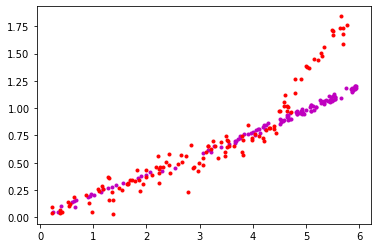

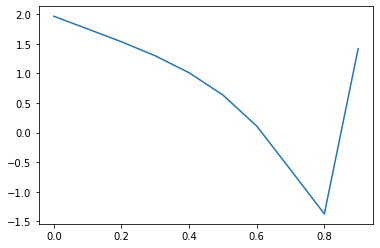

100 tensor(31.1398)
tensor([2.4750], grad_fn=<SqueezeBackward3>) tensor([-0.1574], grad_fn=<SqueezeBackward3>) tensor([0.2232], grad_fn=<SqueezeBackward3>) tensor([0.1524], grad_fn=<SqueezeBackward3>)
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


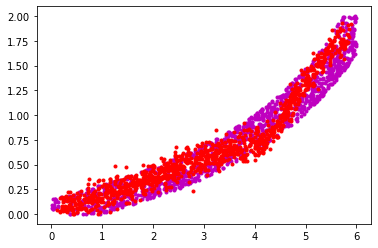

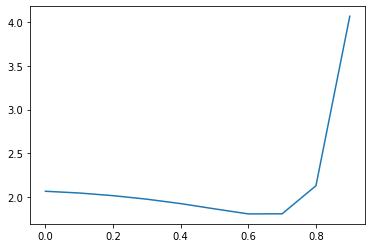

200 tensor(2.8190)
tensor([0.5832], grad_fn=<SqueezeBackward3>) tensor([-3.3129], grad_fn=<SqueezeBackward3>) tensor([0.0697], grad_fn=<SqueezeBackward3>) tensor([0.0274], grad_fn=<SqueezeBackward3>)
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300


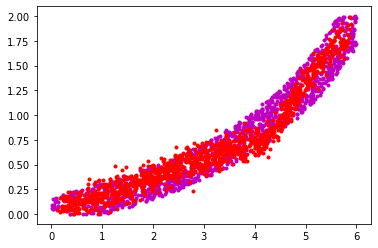

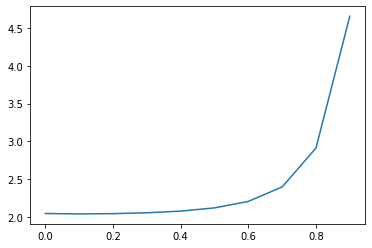

300 tensor(2.7081)
tensor([0.4273], grad_fn=<SqueezeBackward3>) tensor([-3.2559], grad_fn=<SqueezeBackward3>) tensor([0.0669], grad_fn=<SqueezeBackward3>) tensor([0.0221], grad_fn=<SqueezeBackward3>)
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


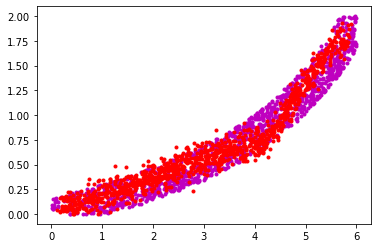

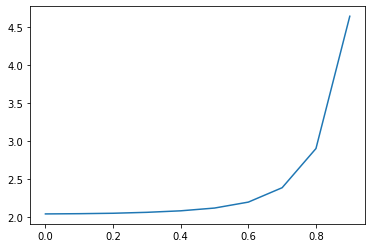

400 tensor(2.7569)
tensor([0.4197], grad_fn=<SqueezeBackward3>) tensor([-3.1573], grad_fn=<SqueezeBackward3>) tensor([0.0683], grad_fn=<SqueezeBackward3>) tensor([0.0235], grad_fn=<SqueezeBackward3>)
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500


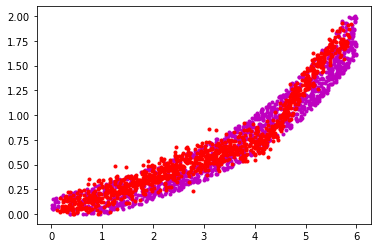

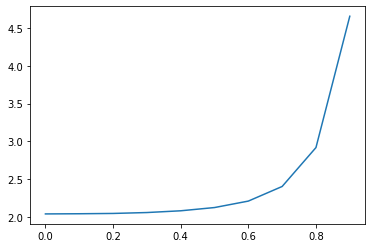

500 tensor(2.7090)
tensor([0.4170], grad_fn=<SqueezeBackward3>) tensor([-3.0589], grad_fn=<SqueezeBackward3>) tensor([0.0676], grad_fn=<SqueezeBackward3>) tensor([0.0230], grad_fn=<SqueezeBackward3>)
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600


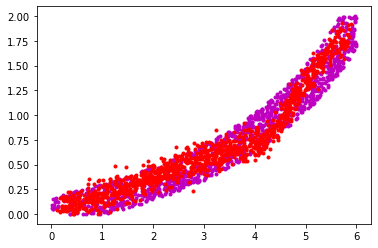

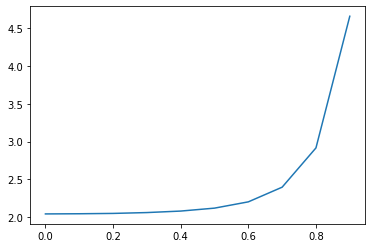

600 tensor(2.7549)
tensor([0.4050], grad_fn=<SqueezeBackward3>) tensor([-2.9770], grad_fn=<SqueezeBackward3>) tensor([0.0695], grad_fn=<SqueezeBackward3>) tensor([0.0229], grad_fn=<SqueezeBackward3>)
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700


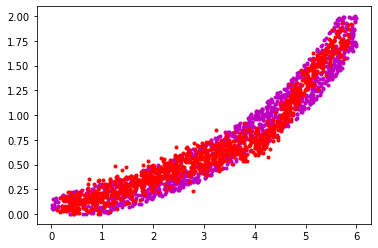

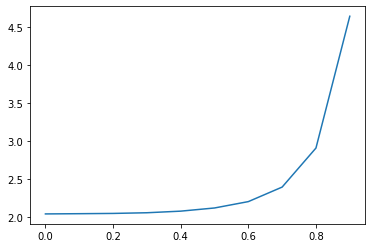

700 tensor(2.6826)
tensor([0.4011], grad_fn=<SqueezeBackward3>) tensor([-2.8898], grad_fn=<SqueezeBackward3>) tensor([0.0701], grad_fn=<SqueezeBackward3>) tensor([0.0228], grad_fn=<SqueezeBackward3>)
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800


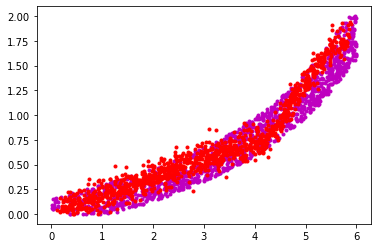

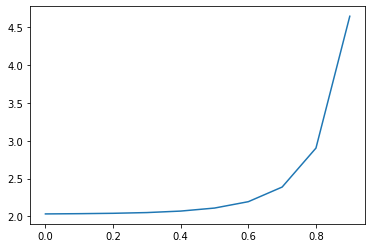

800 tensor(2.7655)
tensor([0.3931], grad_fn=<SqueezeBackward3>) tensor([-2.8029], grad_fn=<SqueezeBackward3>) tensor([0.0700], grad_fn=<SqueezeBackward3>) tensor([0.0237], grad_fn=<SqueezeBackward3>)
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864


In [ ]:
total_epoch=5000
show_epoch_each=100
for epoch in range (total_epoch):
    batches=iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_pi, b_ans) in batches:
        phi, pi, ans = Variable(b_phi), Variable(b_pi), Variable(b_ans)
        loss = Test.loss(phi=phi, pi=pi, answer=ans)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
    print(epoch)
    if np.isnan(train_loss)==True: break
        
    if epoch % show_epoch_each == 0:
        nx, ny, px, py, Hs = plot_metric(threshold=0.1, 
                                         Positive_HM=Positive_HM, Negative_HM=Negative_HM, Net=Test)
        print(epoch, train_loss)
        print(Test.show_m2(), Test.show_lamb(), Test.show_alpha(), Test.show_beta())